# **Challenge 1: Cardiovascular disease diagnosis using cardiac magnetic resonance radiomics and machine learning**

In this project, we aim to leverage machine learning to automatically classify patients'
examinations into five distinct classes using as predictors cardiac magnetic resonance
radiomics features.

## **0. Uploading and Understanding the Dataset**

In [ ]:
import pandas as pd
df = pd.read_csv('ACDC_radiomics.csv')

In [52]:
print(df.head())

   original_shape_Elongation_LV_ED  original_shape_Flatness_LV_ED  \
0                         0.560917                       0.110560   
1                         0.454960                       0.088323   
2                         0.541682                       0.105418   
3                         0.487949                       0.105906   
4                         0.442150                       0.095225   

   original_shape_LeastAxisLength_LV_ED  original_shape_MajorAxisLength_LV_ED  \
0                              6.592758                             59.630582   
1                              5.730218                             64.877933   
2                              6.711577                             63.666027   
3                              6.726159                             63.510529   
4                              7.186765                             75.471150   

   original_shape_Maximum2DDiameterColumn_LV_ED  \
0                                     45.398238

In [53]:
df.shape

(100, 645)

In [54]:
import re

def parse_column(col):
    if col.startswith("original_"):
        parts = col.split("_")
        return {
            "full_name": col,
            "category": parts[1],         # shape, firstorder, glcm, etc.
            "feature": parts[2],          # Strength, Mean, etc.
            "structure": parts[3],        # MYO, LV, RV
            "phase": parts[4]             # ED, ES
        }
    else:
        return None

parsed = [parse_column(col) for col in df.columns if col.startswith("original_")]
parsed = [p for p in parsed if p]  # elimina Nones

# convertir a df
meta_df = pd.DataFrame(parsed)

In [55]:
meta_df

,full_name,category,feature,structure,phase
0,original_shape_Elongation_LV_ED,shape,Elongation,LV,ED
1,original_shape_Flatness_LV_ED,shape,Flatness,LV,ED
2,original_shape_LeastAxisLength_LV_ED,shape,LeastAxisLength,LV,ED
3,original_shape_MajorAxisLength_LV_ED,shape,MajorAxisLength,LV,ED
4,original_shape_Maximum2DDiameterColumn_LV_ED,shape,Maximum2DDiameterColumn,LV,ED
...,...,...,...,...,...
637,original_ngtdm_Busyness_MYO_ES,ngtdm,Busyness,MYO,ES
638,original_ngtdm_Coarseness_MYO_ES,ngtdm,Coarseness,MYO,ES
639,original_ngtdm_Complexity_MYO_ES,ngtdm,Complexity,MYO,ES
640,original_ngtdm_Contrast_MYO_ES,ngtdm,Contrast,MYO,ES


In [56]:
meta_df.describe()

,full_name,category,feature,structure,phase
count,642,642,642,642,642
unique,642,7,101,3,2
top,original_shape_Elongation_LV_ED,glcm,GrayLevelNonUniformity,LV,ED
freq,1,144,18,214,321


In [57]:
meta_df.feature.unique()

array(['Elongation', 'Flatness', 'LeastAxisLength', 'MajorAxisLength',
       'Maximum2DDiameterColumn', 'Maximum2DDiameterRow',
       'Maximum2DDiameterSlice', 'Maximum3DDiameter', 'MeshVolume',
       'MinorAxisLength', 'Sphericity', 'SurfaceArea',
       'SurfaceVolumeRatio', 'VoxelVolume', '10Percentile',
       '90Percentile', 'Energy', 'Entropy', 'InterquartileRange',
       'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median',
       'Minimum', 'Range', 'RobustMeanAbsoluteDeviation',
       'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity',
       'Variance', 'Autocorrelation', 'ClusterProminence', 'ClusterShade',
       'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage',
       'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 'Idmn',
       'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage',
       'JointEnergy', 'JointEntropy', 'MCC', 'MaximumProbability',
       'SumAverage', 'SumEntropy', 'SumSquares', 'DependenceEntropy',
  

In [58]:
meta_df.structure.unique()

array(['LV', 'RV', 'MYO'], dtype=object)

In [59]:
meta_df.category.unique()

array(['shape', 'firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm'],
      dtype=object)

In [60]:
meta_df.phase.unique()

array(['ED', 'ES'], dtype=object)

## **1. Exploratory Data Analysis**

This step is crutial to be done before starting any modelling as it helps us to understand our data and figure out important factors that could influence the model development.

### **1.1. Summary statistics and missing values**

In [61]:
df.dtypes

original_shape_Elongation_LV_ED                 float64
original_shape_Flatness_LV_ED                   float64
original_shape_LeastAxisLength_LV_ED            float64
original_shape_MajorAxisLength_LV_ED            float64
original_shape_Maximum2DDiameterColumn_LV_ED    float64
                                                 ...   
original_ngtdm_Contrast_MYO_ES                  float64
original_ngtdm_Strength_MYO_ES                  float64
height                                            int64
weight                                            int64
class                                            object
Length: 645, dtype: object

In [62]:
df.describe()

,original_shape_Elongation_LV_ED,original_shape_Flatness_LV_ED,original_shape_LeastAxisLength_LV_ED,original_shape_MajorAxisLength_LV_ED,original_shape_Maximum2DDiameterColumn_LV_ED,original_shape_Maximum2DDiameterRow_LV_ED,original_shape_Maximum2DDiameterSlice_LV_ED,original_shape_Maximum3DDiameter_LV_ED,original_shape_MeshVolume_LV_ED,original_shape_MinorAxisLength_LV_ED,...,original_glszm_ZoneEntropy_MYO_ES,original_glszm_ZonePercentage_MYO_ES,original_glszm_ZoneVariance_MYO_ES,original_ngtdm_Busyness_MYO_ES,original_ngtdm_Coarseness_MYO_ES,original_ngtdm_Complexity_MYO_ES,original_ngtdm_Contrast_MYO_ES,original_ngtdm_Strength_MYO_ES,height,weight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.559329,0.116327,7.027303,61.907922,48.331549,67.959597,62.818826,69.083915,7830.536250,34.273933,...,4.278958,0.030509,2.157801e+05,43.418370,0.001517,22.200001,0.012399,0.055277,170.840000,74.960000
std,0.086312,0.044954,2.421983,11.241951,11.736217,12.777552,14.225637,12.871657,4335.369673,6.211781,...,0.657176,0.030895,4.108047e+05,35.480593,0.000714,61.319519,0.009736,0.081740,9.710683,16.632037
min,0.374291,0.046936,3.365035,41.204891,21.095023,46.043458,30.066593,47.053161,1984.375000,21.095961,...,3.193796,0.003233,3.176649e+02,1.770204,0.000443,0.562589,0.001240,0.003402,140.000000,35.000000
25%,0.496768,0.090354,5.547015,55.335903,41.403462,60.588288,54.071708,61.554810,5201.843750,30.218074,...,3.814769,0.014291,5.873236e+04,19.791961,0.001002,2.485099,0.007079,0.012007,165.000000,62.750000
50%,0.562325,0.105700,6.572642,61.729255,45.951022,66.471721,61.683455,67.646128,6743.020833,33.479543,...,4.150802,0.021955,1.295591e+05,34.946317,0.001372,4.207814,0.009971,0.022363,171.500000,75.000000
75%,0.603154,0.123933,7.438589,66.349397,53.235327,73.659458,70.000000,74.787973,9282.125000,38.097940,...,4.638770,0.031424,2.345962e+05,55.753123,0.001819,13.739332,0.013831,0.062622,178.000000,85.000000
max,0.791923,0.286265,16.244584,131.551946,90.138782,143.391074,139.003597,144.371050,26335.375000,59.645360,...,6.251883,0.205567,3.806504e+06,185.157865,0.004126,515.368502,0.066583,0.450330,192.000000,123.000000


In [63]:
df.isnull().sum()

original_shape_Elongation_LV_ED                 0
original_shape_Flatness_LV_ED                   0
original_shape_LeastAxisLength_LV_ED            0
original_shape_MajorAxisLength_LV_ED            0
original_shape_Maximum2DDiameterColumn_LV_ED    0
                                               ..
original_ngtdm_Contrast_MYO_ES                  0
original_ngtdm_Strength_MYO_ES                  0
height                                          0
weight                                          0
class                                           0
Length: 645, dtype: int64

### **1.2. ML Analysis Tools**

In this section, we are going to use different ML tools to visualize patterns in our data, ML tools are specially usefull when having high-dimensionallity data (which is our case). But, before using any ML thecnique, it is essential to scale our data. This is a crutial step as features are in very different ranges of values. If we didn't do that features with larger values could dominate the analysis, even if they weren’t more informative than the other ones.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns=['class'])  # Features
y = df['class']  # Target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The first ML tool that we will apply is the **Liniar Discriminant Analysis (LDA)**, this will allow to optimize the separation of our classes, see how well the classes are separated and see the most important features when separating the classes.

The number of components is:  4
For component 1:
original_shape_MeshVolume_RV_ES                           4.899654
original_shape_VoxelVolume_RV_ES                          4.885090
original_gldm_GrayLevelNonUniformity_RV_ES                4.786138
original_shape_Maximum2DDiameterSlice_RV_ES               3.747847
original_firstorder_Kurtosis_LV_ES                        3.084156
original_glcm_Correlation_MYO_ES                          3.080766
original_glrlm_GrayLevelNonUniformity_RV_ES               2.938208
original_shape_Maximum2DDiameterRow_RV_ES                 2.911044
original_glszm_GrayLevelNonUniformityNormalized_MYO_ES    2.909973
original_gldm_DependenceNonUniformityNormalized_MYO_ES    2.772650
dtype: float64


For component 2:
original_shape_Maximum2DDiameterSlice_RV_ES               2.625060
original_shape_MeshVolume_RV_ES                           2.621418
original_shape_VoxelVolume_RV_ES                          2.617609
original_shape_MinorAxisLength_RV_ES          

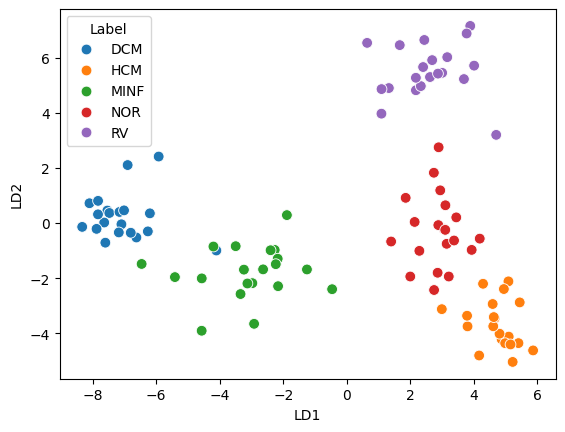

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import seaborn as sns

# Optimize separation between classes
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_scaled, y)

# Goodness of class separation
n_components = X_lda.shape[1]
print("The number of components is: ", n_components)
lda_cols = [f"LD{i+1}" for i in range(n_components)]
df_lda = pd.DataFrame(X_lda, columns=lda_cols)
df_lda["Label"] = y
sns.scatterplot(data=df_lda, x="LD1", y="LD2", hue="Label", palette="tab10", s=60)

From the plot, it can be seen that the components 1 and 2 are quite good at discriminating classes, considering that there are four components, we can think that the classes can be well separated. In order to ensure that we will make a Pairwise LDA component plot.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_lda, hue='Label', palette='tab10')
plt.suptitle('Pairwise LDA component plots', y=1.02)
plt.show()

From the plot, we can ensure that using the different components, the classes can be well separated using the different components. For each of this components we will select the top ten mostly conributing features by looking at the coefficients. From that, we will create a unique set of features.

In [ ]:
top_features = set()  # to store top features

# Look for the top ten features
for i in range(X_lda.shape[1]):
    lda_coefs = pd.Series(lda.coef_[i], index=X.columns)
    top10 = lda_coefs.abs().sort_values(ascending=False).head(10)

    print(f"\nFor component {i+1}:")
    for feature, coef in top10.items():
        print(f"{feature}: {coef:.4f}")

        # Add the feature in the top feature list
        if feature not in top_features:
            top_features.add(feature)

# Display the selected features
print("\nUnique top contributing features across all components (with coefficients):")
for feature in sorted(top_features):
    print(f"{feature}")
print("\nTotal number of features: ", len(top_features))

Regarding to the most important features, we can see printed the top ten most important features of each component. Having a quick overview we can see that those features are associated with the phase end of systole (ES) and the most relevant structures are right ventricle (RV) and myocardium (MYO).

Now we will create a heatmap in order to see what is the correlation with each LDA component.

In [ ]:
# Create a dataframe with only the selected features
X_selected = X[list(top_features)]

# Keep only the LDA components
lda_components = df_lda.drop(columns='Label')

# Compute the correlation: components (rows) vs features (columns)
corr_matrix = lda_components.corrwith(X_selected, axis=0)
cross_corr = pd.DataFrame(
    np.corrcoef(lda_components.T, X_selected.T)[:lda_components.shape[1], lda_components.shape[1]:],
    index=lda_components.columns,
    columns=X_selected.columns
)

# Plot the heatmap
plt.figure(figsize=(15, 3))
sns.heatmap(cross_corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation: LDA Components (rows) vs Selected Features (columns)', fontsize=16)
plt.xlabel('Features')
plt.ylabel('LDA Components')
plt.show()

It can be seen that for eache component different set of features and with different intensity are correlated. this allows to optimize the class separation in the reduced dimensional space and be able to separate better the different classes.

Finally, it can be usefull to look for the correlations among features in order to see if they are redundant.

In [ ]:
# Create a DataFrame with the selected features
X_top_features = X[list(top_features)]

# Compute correlation matrix
feature_corr = X_top_features.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(feature_corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation matrix between Top Selected Features', fontsize=18)
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

It can be seen that some features are highly correlated (specially some with same phase and structure). This suggests us that some feature reduction could be done despite the optimal components found. This would be a necesary step as having highly correlated features is not adding more relevant information in our model.

Now, it is time to use the **Principal Component Analysis (PCA)**, this will allow us to see which features explain most of the variance. As it is an unsupervised thecnique, we have to consider that it will not help us to find which features can mostly separate class, it just will explain the variance.

We will start by training a simple classifier, in this case a logistic regression on different number of PCs and see how the classification accuracy changes.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

scores = []

for n_pcs in range(2, 20):  # Try from 2 to 30 PCs
    pca = PCA(n_components=n_pcs)
    X_pca = pca.fit_transform(X_scaled)

    clf = LogisticRegression(max_iter=1000)
    score = cross_val_score(clf, X_pca, y.values, cv=5).mean()  # 5-fold CV
    scores.append(score)

# Plot accuracy vs number of PCs
plt.figure(figsize=(8,5))
plt.plot(range(2, 20), scores, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cross-validated Accuracy')
plt.title('Classification performance vs Number of PCs')
plt.grid(True)
plt.show()

In this plot we can see that the number of PCs that seems to give the better accuracy is 13, so we'll be using 13 PCs.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pca = PCA(n_components=13)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
plt.figure()
plt.plot(range(1, 14), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Cumulative Explained Variance by PCA")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.show()

# Show the component contribution
loadings = pca.components_
feature_names = X.columns
n_components_to_display = 13
top_n = 13

for i in range(n_components_to_display):
    component_loadings = loadings[i]
    abs_loadings = np.abs(component_loadings)
    top_indices = abs_loadings.argsort()[::-1][:top_n]

    print(f"\nFor principal component {i+1}:")
    for idx in top_indices:
        print(f"{feature_names[idx]} \t {component_loadings[idx]:.4f}")

From this plot we can see that for 13 components the explained variance is more than 90%, considering that the number of features is 644, this means that most of the features are correlated and so their contibution of information is redundant. It is important to highlight that we observed that PC1 was driven by first-order intensity statistics related to the RV and LV at ED and ES phases. PC2 captured geometric variations in the myocardium and PCs 3–13 were characterized by texture-based features across all anatomical structures. The separation of feature types across principal components highlights that different sources of variation (shape, intensity, texture) are present.

Let's try and plot the first 13 PCs against each other to see if the classes are separated well.

In [ ]:
import pandas as pd
pc_df = pd.DataFrame(X_pca[:, :13], columns=[f'PC{i+1}' for i in range(13)])
pc_df['label'] = y.values

sns.pairplot(pc_df, hue='label', palette='tab10')
plt.suptitle('Pairwise PCA component plots', y=1.02)
plt.show()

We have seen that the first 13 principal components explain the 90%% of the variance so we'll do a heatmap of the components of each PC to see the similarity between them.

In [ ]:
n_components = 13
loadings = pd.DataFrame(
    pca.components_.T[:, :n_components],
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X.columns
)

plt.figure(figsize=(12,8))
sns.heatmap(loadings, cmap='coolwarm', center=0)
plt.title('PCA Components Heatmap')
plt.show()

The heatmap is too messy so we will select the top 10 features and represent them to better visualize the correlation between PCs.

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

top_features = []

# Pick top 10 features for each principal component
for pc in loadings.columns:
    top = loadings[pc].abs().sort_values(ascending=False).head(10).index
    top_features.extend(top)

# Remove duplicates
top_features = list(set(top_features))

# Create a smaller loadings matrix
small_loadings = loadings.loc[top_features]

# Plot the small heatmap
plt.figure(figsize=(12,8))
sns.heatmap(small_loadings, cmap='coolwarm', center=0, annot=False)
plt.title('Top contributing features to principal components')
plt.show()

Once having decided how many PCs are useful, we can plot a UMAP using those 13 principal components to even get the 13 dimensions down to 2 dimensions. However, UMAP might not be classifying visually the labels because it is a nonlinear projection mainly optimized for visualization, not classification.

In [ ]:
import umap

#UMAP after PCA
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

#Plot UMAP
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=y.values,
    palette='tab10',
    s=60,
    alpha=0.8
)
plt.title('UMAP projection after PCA (colored by predicted class)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Predicted Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Now, it is time to use **t-SNE**, that will allow us to visualize the high dimensional data in 2D and identify local structures (small clusters, subgroups).

<Axes: xlabel='Dim1', ylabel='Dim2'>

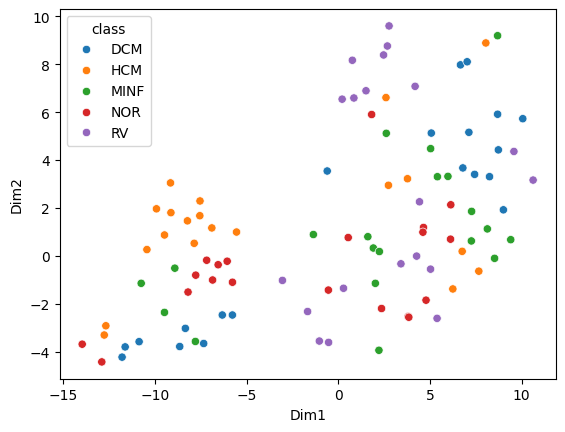

In [ ]:
from sklearn.manifold import TSNE

#Fit t-SNE on the PCA-transformed data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

#Plot t-SNE colored by TRUE labels
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=y.values,
    palette='tab10',
    s=60,
    alpha=0.8
)
plt.title('t-SNE projection after PCA (colored by TRUE labels)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='True Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
len(top_features) #120 features
top_features # top features contributing to the first 13 PCs

The results show good separation between the RV group that is clustered at the top right and the HCM group which is mostly packed in the bottom right eventhough there are some outliers. MINF and DCM are very mixed and NOR is scattered between all of the groups.

However, we don't have to worry. t-SNE prioritizes local structures, not class separation, PCA classification is what matters most.

Finally, we will perform a **k-means** claustering in order to see how well the different classes can be separated using all the features we have.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Compare to actual labels
ct = pd.crosstab(clusters, df["class"])
print(ct)

class  DCM  HCM  MINF  NOR  RV
row_0                         
0        0    1     1    0   0
1        5   11     5    8   3
2       12    6    14   10  17
3        0    0     0    1   0
4        3    2     0    1   0


Clausters 0, 3 and 4 have very few elements, which will be not relevant for our analysis. Regarding to clauster 2 it seems that the algorithm is capable of separating classes DCM, MINF and RV from the others but not distinguishing among them with this set of features. Clauster 1 seems to be slightly good at identifying HCM from the rest of the classes but with some problems. This suggests us that for discriminating the different classes some feature selection and engeneering should be done.

It is important to highlight that results in the k-means are similar to the ones obtained in the t-SNE, wich makes the results consistant. What we can ensure is that from our dataset, HCM is very different from MINF and RV, the other classes are not that different from the rest. In order to distinguish between all of them, some feature engeneering and reduction should be done.

### **1.3. Plotting Non-Radiomic Features**

This section aims to do some visual representation of the non-radiomic features in the dataset.

First of all, we will see the class distribution in a bar plot. It can be seen that the nomber of classes is balanced in the dataset.

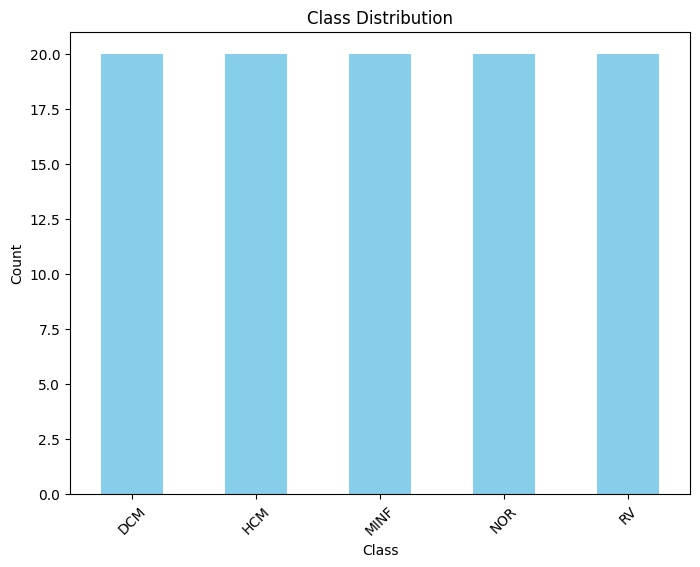

In [73]:
# Adistributions of class
class_counts = df['class'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Now, we will plot the distribution of height and weight. As it can be seen they are normally distriibuted.

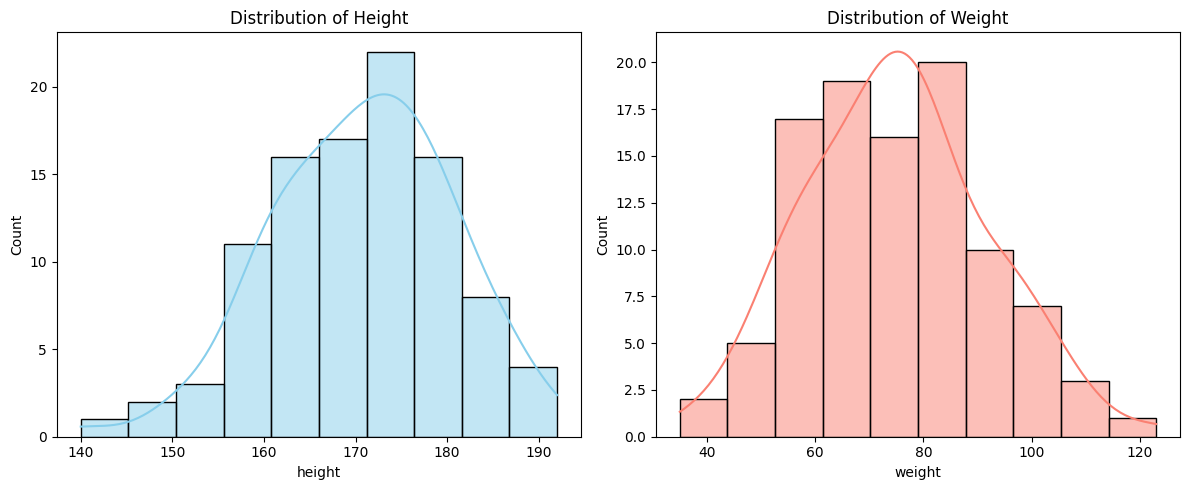

In [74]:
# distributions of height and weight
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['height'], kde=True, ax=axes1[0], color='skyblue')
axes1[0].set_title('Distribution of Height')
sns.histplot(df['weight'], kde=True, ax=axes1[1], color='salmon')
axes1[1].set_title('Distribution of Weight')
plt.tight_layout()
plt.show()

Moreover, we will see the distribution of those variables by class. It can be seen that there are not huge differences in height, but there are slightly ones in weight.

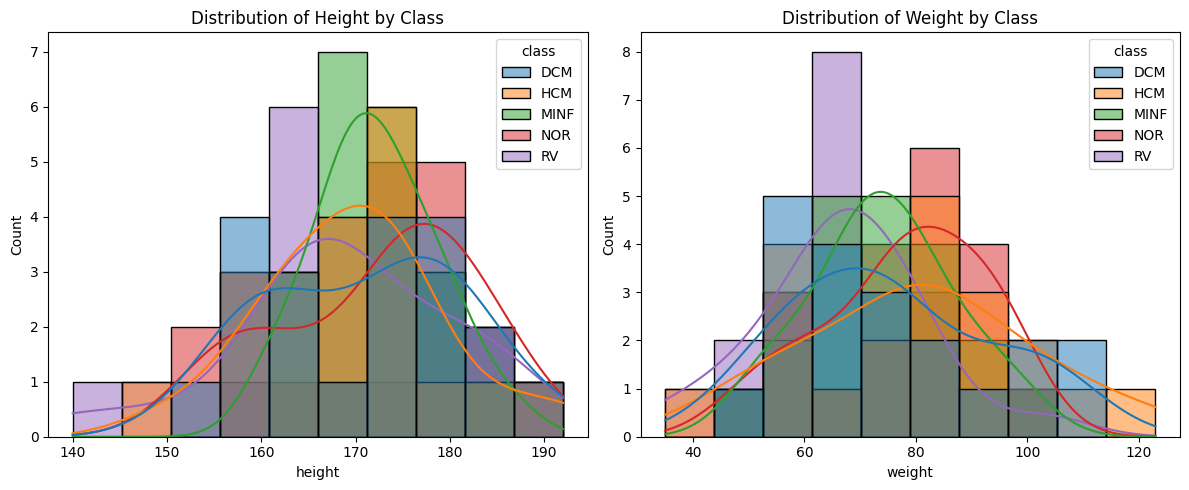

In [75]:
# distributions of height and weight by class
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df, x='height', hue='class', kde=True, ax=axes2[0])
axes2[0].set_title('Distribution of Height by Class')
sns.histplot(data=df, x='weight', hue='class', kde=True, ax=axes2[1])
axes2[1].set_title('Distribution of Weight by Class')
plt.tight_layout()
plt.show()

Finally, we will do a scatterplot of Height vs Weight, which can be seen that are a little correlated. When colouring them by class, it is not possible to distinguish the different classes.

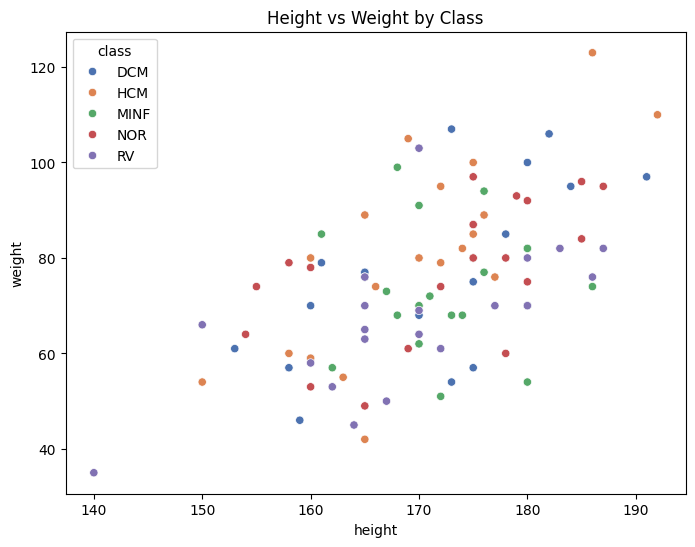

In [76]:
# scatter plot of height vs weight colored by class
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='height', y='weight', hue='class', palette='deep')
plt.title('Height vs Weight by Class')
plt.show()

## **2. Training and Validation Set Creation**

In order to be able to get a good fitting of the model and a reliable metric for the performance it is necessary to separate the dataset into three different sets:

- **Training set (60–80%)**: Used to fit the model and learn patterns from the data.

- **Validation set (10–20%)**: Used to tune hyperparameters and monitor model performance during training.

- **Test set (10–20%)**: Used to evaluate the final model’s performance on unseen data.

This section aims to devide the dataset into this groups in order to have it prepared to build our models.

First of all it is important to separete our target variable class from the rest of the features.

In [77]:
import pandas as pd
X = df.drop(columns=['class'])  # Features
y = df['class']  # Target

In [78]:
X

,original_shape_Elongation_LV_ED,original_shape_Flatness_LV_ED,original_shape_LeastAxisLength_LV_ED,original_shape_MajorAxisLength_LV_ED,original_shape_Maximum2DDiameterColumn_LV_ED,original_shape_Maximum2DDiameterRow_LV_ED,original_shape_Maximum2DDiameterSlice_LV_ED,original_shape_Maximum3DDiameter_LV_ED,original_shape_MeshVolume_LV_ED,original_shape_MinorAxisLength_LV_ED,...,original_glszm_ZoneEntropy_MYO_ES,original_glszm_ZonePercentage_MYO_ES,original_glszm_ZoneVariance_MYO_ES,original_ngtdm_Busyness_MYO_ES,original_ngtdm_Coarseness_MYO_ES,original_ngtdm_Complexity_MYO_ES,original_ngtdm_Contrast_MYO_ES,original_ngtdm_Strength_MYO_ES,height,weight
0,0.560917,0.110560,6.592758,59.630582,45.398238,64.776539,64.007812,65.199693,5674.000000,33.447817,...,4.842353,0.053567,40384.123570,19.552355,0.000993,36.034390,0.010496,0.091329,184,95
1,0.454960,0.088323,5.730218,64.877933,40.311289,64.140471,61.000000,67.446275,5015.833333,29.516875,...,4.638405,0.028344,130808.332098,29.225756,0.000722,17.238110,0.006596,0.045024,160,70
2,0.541682,0.105418,6.711577,63.666027,48.041649,66.843100,59.135438,68.080834,7817.666667,34.486772,...,4.390950,0.041404,92088.926893,20.732684,0.001106,13.916093,0.004455,0.069372,165,77
3,0.487949,0.105906,6.726159,63.510529,44.407207,66.370174,66.007575,66.475559,5629.166667,30.989912,...,5.632728,0.150855,5232.431686,5.158496,0.000848,216.183657,0.025431,0.208797,159,46
4,0.442150,0.095225,7.186765,75.471150,68.066144,77.472576,50.487622,77.472576,8550.083333,33.369563,...,4.942891,0.040613,91705.803093,18.086404,0.000710,41.886924,0.005266,0.123346,165,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.606237,0.264847,16.244584,61.335759,46.324939,68.593003,70.064256,70.377553,20000.500000,37.184019,...,4.020276,0.014766,397739.682708,35.712016,0.001875,1.734846,0.002444,0.023954,186,76
96,0.507357,0.102727,7.177584,69.870562,42.426407,75.663730,76.006579,76.661594,9423.750000,35.449290,...,4.094251,0.013379,152663.114725,39.264262,0.001726,3.087926,0.009951,0.018479,187,82
97,0.571326,0.099567,6.983155,70.134966,54.000000,79.555012,73.000000,79.555012,10471.333333,40.069911,...,3.242586,0.010246,342202.419693,59.062319,0.001263,1.744393,0.009936,0.007259,167,50
98,0.645987,0.247128,12.974486,52.501013,44.643029,57.558666,58.008620,58.429445,12517.750000,33.914988,...,3.550906,0.014347,161138.065902,42.061917,0.001343,3.895755,0.016194,0.011354,180,80


Then, we will do a simple train-test split in order to generate a train set and a test set. We will make the test set to include 20% of our data and beeing stratified, meaning that the proportion of each target class will be preserved.

In [79]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

However, we have two different sets now, but we need to create an additional validation set in order to use it to tune the hyperparameters of our model. For that we will use different thecniques to do that.

First of all we will do a **simple splitting** (as done with the test set), where 20% of the data generated before will go to the validation set and the rest will be left to training set. It is important to remark that the splitting is stratifyed as well in this case.

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

Additionally, we will make a stratified **K-Fold cross-validation** strategy with 5 splits (so that a 20% of the data is used as validation each time). This means that the dataset will be divided into 5 folds preserving the class distribution and the model will be trained and validated 5 times, each time using a different fold for validation and the remaining ones for training.

In [81]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Finally, we will use the **leave one out** method wich is an other cross-validation approach that in this case will use just 1 sample as validation and rest of the samples will be left as training set. The model will be validated as many times as samples are in the dataset.

In [82]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

## **3. Baseline Models**

Since we are asked to include all the features and only have 100 samples, the accurate training of the model will be a bit challenging. To address this, we will use the dataset mentioned above along with three training and validation methods: simple split, 5-fold cross-validation, and leave-one-out cross-validation. Since the problem is a supervised classification task, we will try the following models:

- SVM (Suport Vector Machine): A powerful classifier that works well with high-dimensional data (more features than samples). The SVM with a non-linear kernel  is particularly suited for complex relationships between features.

- NN (Neural Networks): Neural networks are effective for learning non-linear patterns in data. Given the relatively small dataset, we will use a simple feedforward neural network (e.g., MLPClassifier), which balances model complexity and training requirements.

- KNN (K nearest neighbors): A simple and interpretable method that classifies based on the nearest neighbors. It can be useful when relationships between data points are not explicitly modeled but are local.

- RF (Random Forest): A robust ensemble method that reduces overfitting by averaging predictions from multiple decision trees. It’s effective in handling high-dimensional data.

- XGB (Extreme Gradient Boosting): A powerful gradient boosting algorithm that has shown strong performance in many classification tasks, especially when dealing with complex feature interactions.

The pipeline will involve standardizing the data, training, validating, and testing the model using the three techniques mentioned above. Afterward, we will discuss the results of each case. For evaluation, we will use common metrics such as AUC (since the classes are balanced), and additional metrics from the confusion matrix, including accuracy, specificity, and sensitivity.

In [83]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_train_val = label_encoder.fit_transform(y_train_val)
y_val = label_encoder.transform(y_val) 
y_test = label_encoder.transform(y_test)  

In [84]:
# first we are going to create all the models with their corresponding hyperparameters to train

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    'SVM': SVC(probability=True),
    'NN': MLPClassifier(max_iter=500, random_state=42),
    'KNN': KNeighborsClassifier(),
    'RF': RandomForestClassifier(random_state=42),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'NN': {
        'hidden_layer_sizes': [(50,), (100,), (150,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'learning_rate': ['constant', 'adaptive']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'RF': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGB': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

In [ ]:
# now we create a function to fit and evaluate each model depending on if we have simple split or cross validation

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

def grid_search_model(model, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, cv=5, use_cv=True):
    if use_cv:
        # if we have cv we use training and validation in the grid search
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, refit=True, return_train_score=True)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
       
        y_val_pred = cross_val_predict(best_model, X_train, y_train, cv=cv, n_jobs=-1)
        if hasattr(best_model, "predict_proba"):
            y_val_prob = cross_val_predict(best_model, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)
        else:
            y_val_prob = None

        val_accuracy = accuracy_score(y_train, y_val_pred)
        val_precision = precision_score(y_train, y_val_pred, average='macro')
        val_recall = recall_score(y_train, y_val_pred, average='macro')
        val_f1 = f1_score(y_train, y_val_pred, average='macro')
        val_conf_matrix = confusion_matrix(y_train, y_val_pred)
        val_auc = roc_auc_score(y_train, y_val_prob, multi_class='ovr') if y_val_prob is not None else None

    else:
        #if we have simple split we just fit the model on the training and evaluate on the validation
        model.fit(X_train, y_train)
        best_model = model
        y_val_pred = best_model.predict(X_val)
        
        if hasattr(best_model, "predict_proba"):
            y_val_prob = best_model.predict_proba(X_val)
        else:
            y_val_prob = None

        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred, average='macro')
        val_recall = recall_score(y_val, y_val_pred, average='macro')
        val_f1 = f1_score(y_val, y_val_pred, average='macro')
        val_conf_matrix = confusion_matrix(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr') if y_val_prob is not None else None

    y_test_pred = best_model.predict(X_test)
    if hasattr(best_model, "predict_proba"):
        y_test_prob = best_model.predict_proba(X_test)
    else:
        y_test_prob = None

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr') if y_test_prob is not None else None

    return (
        best_model,
        (val_accuracy, val_auc, val_precision, val_recall, val_f1, val_conf_matrix),
        (test_auc, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix),
        (grid_search.best_params_ if use_cv else None)
    )

In [ ]:
# we create a dataframe to organize all the results

results_df = pd.DataFrame(columns=[
    'Model', 'Validation Method', 'Best Parameters', 'Validation Accuracy', 
    'Validation AUC', 'Validation Precision', 'Validation Recall', 
    'Validation F1 Score', 'Test Accuracy', 'Test AUC', 'Test Precision', 
    'Test Recall', 'Test F1 Score'
])

# for the simple split case

for model_name, model in models.items():
    print(f'Training {model_name}')
    
    best_model, val_metrics, test_metrics, best_params = grid_search_model(
        model, param_grids[model_name],
        X_train, y_train, X_val, y_val, X_test, y_test,
        cv=None, use_cv=False  
    )

    val_accuracy, val_auc, val_precision, val_recall, val_f1, val_conf_matrix = val_metrics
    test_auc, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = test_metrics

    results_dict = {
        'Model': model_name,
        'Validation Method': 'Simple Split',
        'Best Parameters': best_params,
        'Validation Accuracy': val_accuracy,
        'Validation AUC': val_auc,
        'Validation Precision': val_precision,
        'Validation Recall': val_recall,
        'Validation F1 Score': val_f1,
        'Test Accuracy': test_accuracy,
        'Test AUC': test_auc,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)

Training SVM
Training NN
Training KNN


C:\Users\lclai\AppData\Local\Temp\ipykernel_23888\1414218091.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

Training RF
Training XGB


In [ ]:
# for the 5 fold cv case

for model_name, model in models.items():
    print(f'Training {model_name}')

    best_model, val_metrics, test_metrics, best_params = grid_search_model(
        model, param_grids[model_name],
        X_train_val, y_train_val, X_val, y_val, X_test, y_test,
        cv=kfold, use_cv=True
    )

    val_accuracy, val_auc, val_precision, val_recall, val_f1, val_conf_matrix = val_metrics
    test_auc, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = test_metrics

    results_dict = {
        'Model': model_name,
        'Validation Method': '5 fold CV',
        'Best Parameters': best_params,
        'Validation Accuracy': val_accuracy,
        'Validation AUC': val_auc,
        'Validation Precision': val_precision,
        'Validation Recall': val_recall,
        'Validation F1 Score': val_f1,
        'Test Accuracy': test_accuracy,
        'Test AUC': test_auc,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)


Training SVM
Training NN
Training KNN
Training RF
Training XGB


In [91]:
# for the leave one out case

for model_name, model in models.items():
    print(f'Training {model_name}')

    best_model, val_metrics, test_metrics, best_params = grid_search_model(
        model, param_grids[model_name],
        X_train_val, y_train_val, X_val, y_val, X_test, y_test,
        cv=loo, use_cv=True
    )

    val_accuracy, val_auc, val_precision, val_recall, val_f1, val_conf_matrix = val_metrics
    test_auc, test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = test_metrics

    results_dict = {
        'Model': model_name,
        'Validation Method': 'LeaveOneOut',
        'Best Parameters': best_params,
        'Validation Accuracy': val_accuracy,
        'Validation AUC': val_auc,
        'Validation Precision': val_precision,
        'Validation Recall': val_recall,
        'Validation F1 Score': val_f1,
        'Test Accuracy': test_accuracy,
        'Test AUC': test_auc,
        'Test Precision': test_precision,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)


Training SVM
Training NN


c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training KNN
Training RF
Training XGB


In [92]:
results_df

,Model,Validation Method,Best Parameters,Validation Accuracy,Validation AUC,Validation Precision,Validation Recall,Validation F1 Score,Test Accuracy,Test AUC,Test Precision,Test Recall,Test F1 Score
0,SVM,Simple Split,None,0.4375,0.771154,0.352381,0.466667,0.386667,0.40,0.709375,0.480000,0.40,0.388889
1,NN,Simple Split,None,0.3750,0.585256,0.152727,0.333333,0.206667,0.45,0.656250,0.555000,0.45,0.374286
2,KNN,Simple Split,None,0.3750,0.772756,0.480000,0.400000,0.400000,0.35,0.681250,0.408333,0.35,0.347619
3,RF,Simple Split,None,0.5625,0.875321,0.636667,0.583333,0.586667,0.65,0.834375,0.636667,0.65,0.640476
4,XGB,Simple Split,None,0.6250,0.844551,0.713333,0.633333,0.656508,0.50,0.828125,0.464286,0.50,0.466883
5,SVM,5 fold CV,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.8000,0.908008,0.806723,0.800000,0.801340,0.75,0.962500,0.850000,0.75,0.734762
6,NN,5 fold CV,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.7500,0.843750,0.745789,0.750000,0.742396,0.70,0.812500,0.700000,0.70,0.686667
7,KNN,5 fold CV,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6375,0.850488,0.675098,0.637500,0.644627,0.55,0.829688,0.613333,0.55,0.558730
8,RF,5 fold CV,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.8000,0.935156,0.812655,0.800000,0.798986,0.70,0.859375,0.733333,0.70,0.692063
9,XGB,5 fold CV,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",0.7500,0.940234,0.754510,0.750000,0.746575,0.80,0.953125,0.803333,0.80,0.791270


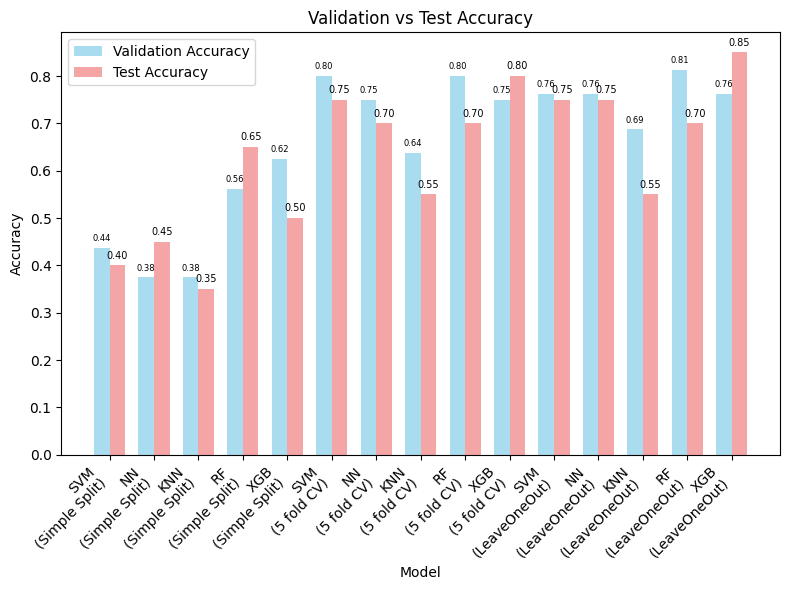

In [101]:
#to finalize with this part we can do a simple plot to compare the different models, validation and test

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
index = np.arange(len(results_df))

ax.bar(index, results_df['Validation Accuracy'], bar_width, label='Validation Accuracy', alpha=0.7, color='skyblue')
ax.bar(index + bar_width, results_df['Test Accuracy'], bar_width, label='Test Accuracy', alpha=0.7, color='lightcoral')

validation_types = results_df['Validation Method'].values
xticks_labels = [f"{model}\n({validation})" for model, validation in zip(results_df['Model'], validation_types)]

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(xticks_labels, rotation=45, ha='right')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Validation vs Test Accuracy')

for i in range(len(results_df)):
    ax.text(i, results_df['Validation Accuracy'][i] + 0.01, 
            f"{results_df['Validation Accuracy'][i]:.2f}", ha='center', va='bottom', fontsize=6)
    ax.text(i + bar_width, results_df['Test Accuracy'][i] + 0.01, 
            f"{results_df['Test Accuracy'][i]:.2f}", ha='center', va='bottom', fontsize=7)

ax.legend()
plt.tight_layout()
plt.show()

### Interpretation of the Results

The evaluation of several models (SVM, Neural Network, KNN, Random Forest, XGBoost) was carried out using three different validation methods: simple split, 5-Fold Cross-Validation, and Leave-One-Out Cross-Validation.

When using the simple split validation method, Random Forest (RF) and XGBoost (XGB) outperformed the other models, such as SVM, Neural Networks (NN), and KNN. Random Forest achieved a validation accuracy of 56.25%, a validation AUC of 0.875, and high precision and recall. XGBoost showed a slightly better validation accuracy of 62.5% but had a lower recall (0.633) compared to Random Forest, indicating a trade-off between the two metrics. The test results for both Random Forest and XGBoost showed a decrease in performance, suggesting that the models may be overfitting to the training data.

During 5-Fold Cross-Validation with hyperparameter tuning, SVM achieved a significant improvement, reaching a validation accuracy of 80%, with high precision and recall. XGBoost also performed well, achieving a validation accuracy of 75%. Neural Networks showed good performance as well, with a validation accuracy of 75%, but their performance on the test set slightly declined, with a test accuracy of 70%. The application of hyperparameter tuning in the 5-Fold Cross-Validation helped improve model generalization compared to the results from the simple split validation, particularly for models like SVM and Neural Networks.

In the Leave-One-Out Cross-Validation, SVM, Neural Networks, and XGBoost remained the top performers, with SVM achieving the highest AUC (0.971875) and demonstrating strong discrimination between classes. The models' performances were generally consistent with the trends observed during 5-Fold Cross-Validation, indicating that the models were well-optimized through the tuning process. XGBoost also showed impressive results, with a validation AUC of 0.934570 and a test AUC of 0.959375, which suggests good model generalization across all validation methods.

It is important to note that overfitting is a concern in this scenario due to the relatively small sample size (100 samples) in comparison to the large number of features (644). This makes overfitting a likely issue for some models. Techniques like regularization, feature selection, and proper cross-validation are recommended to mitigate overfitting. Moreover, methods such as early stopping can help further improve the generalization of neural networks.

Regarding performance metrics, accuracy is a reasonable metric, given the balanced nature of the classes. However, in a clinical context, it might be more appropriate to prioritize metrics like recall, especially when false negatives need to be minimized (e.g., in medical diagnostics). This would ensure that more instances of the positive class are correctly identified, which is crucial for minimizing the risk of missing important cases.

In conclusion, the initial evaluation suggests that SVM, Neural Networks, and XGBoost are well-suited for the task, but further model improvement could be achieved through advanced techniques like feature selection, ensemble methods, and synthetic data generation. Hyperparameter tuning has proven to be effective in improving model performance, and the models show promise for further refinement.

## **4. Feature Engeneering and model Enhancement**

## **5. Results Analysis**